# ELPv2

In [766]:
import pandas as pd

df1 = pd.read_csv('./data/E2023-2024.csv')
df1['Div'] = 'E2023-2024'
df2 = pd.read_csv('./data/E2022-2023.csv')
df2['Div'] = 'E2022-2023'
df3 = pd.read_csv('./data/E2021-2022.csv')
df3['Div'] = 'E2021-2022'
df4 = pd.read_csv('./data/E2020-2021.csv')
df4['Div'] = 'E2020-2021'
df5 = pd.read_csv('./data/E2019-2020.csv')
df5['Div'] = 'E2019-2020'

all_df = pd.concat([df1, df2, df3, df4, df5])
all_df.to_csv('all_df.csv')

In [697]:
from perspective import PerspectiveWidget
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score

def score_model(X_train, X_valid, y_train, y_valid, preprocesor, model=DecisionTreeRegressor, flush=True, **kwargs):
    
    random_state = kwargs.get('random_state', 42)
    model_tree = model(random_state=random_state, **kwargs)
    
    tree_pipeline = Pipeline(steps=[
        # ('preprocesor', preprocesor),
        ('model', model_tree),
    ])
    
    tree_pipeline.fit(X_train, y_train)
    preds = tree_pipeline.predict(X_valid)
    
    mae = mean_absolute_error([round(i) for i in preds], y_valid)
    acc = accuracy_score([round(i) for i in preds], y_valid)
    if flush:
        print(f'\rMAE: {mae} | Acc Score: {acc}| {kwargs=}', end='', flush=True)
    return mae, preds


def display_plot(x_values, y_values, xlabel: str = '', ylabel: str = '', title: str = '', label: str = 'x'):

    plt.figure(figsize=(6, 3))
    plt.plot(x_values, y_values, linestyle='-', color='b', label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.show()

### Features

In [698]:
from utils import add_wldha
features = {
     'Div': 'League Division',
    
     'Date': 'Match Date (dd/mm/yy)',   # merge
     'Time': 'Time of match kick off',  # merge
        
     'HomeTeam': 'Home Team',
     'AwayTeam': 'Away Team',
     'Referee': 'Match Referee',

     'FTR': 'Final Result',
        
     'B365H': 'Bet365 home win odds',
     'B365D': 'Bet365 draw odds',
     'B365A': 'Bet365 away win odds',
}

_X = all_df[features.keys()].copy()

### General

In [699]:
X = _X.copy()

X.Div = X['Div'].astype('category').cat.codes
X.Referee = X['Referee'].astype('category').cat.codes

# X.HomeTeam = X['HomeTeam'].astype('category').cat.codes
# X.AwayTeam = X['AwayTeam'].astype('category').cat.codes

### FTR

In [700]:
ftr = {'H': 1, 'A': 2, 'D': 0}
# 
def ftr_cat_codes(X: pd.DataFrame):
    X['FTR_cat'] = X['FTR'].astype('category')
    X.FTR = X['FTR_cat'].cat.codes
    ftr.update(dict(zip(X['FTR_cat'], X['FTR_cat'].cat.codes)))
    X.drop('FTR_cat', axis=1, inplace=True)

def ftr_default(X: pd.DataFrame):
    X['FTR'] = X['FTR'].replace(ftr)


In [701]:
ftr_default(X)

/var/folders/bh/54y95t956h793hywb9szy8gh0000gn/T/ipykernel_24013/2520521957.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['FTR'] = X['FTR'].replace(ftr)


In [702]:
ftr

{'H': 1, 'A': 2, 'D': 0}

### Add stats

In [703]:
add_wldha(X)

### Dates

In [704]:
def get_match_week(X: pd.DataFrame):
    X['DayDiff'] = (X['Date'] - X['Date'].min()).dt.days
    X['MatchWeek'] = (X['DayDiff'] // 7) + 1
    X.drop(['DayDiff'], axis=1, inplace=True)


In [705]:
X['Date'] = pd.to_datetime(X.Date, format="%d/%m/%Y")
X = X.sort_values(by='Date')

get_match_week(X)

X['Time'] = X.Time.str.replace(':.+', '', regex=True).astype(int)  # only hours

# X['Year'] = X['Date'].dt.year
# X['Month'] = X['Date'].dt.month
# X['Day'] = X['Date'].dt.day
X['DayOfWeek'] = X['Date'].dt.dayofweek

X.drop('Date', axis=1, inplace=True)

In [706]:
num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns

### Train Test Split

In [707]:
from sklearn.model_selection import train_test_split


def get_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

def get_hist_train_last_valid(X):
    X_train = X[X['Div'] != X['Div'].max()]
    y_train = X[X['Div'] != X['Div'].max()].FTR
    
    X_valid = X[X['Div'] == X['Div'].max()]
    y_valid = X[X['Div'] == X['Div'].max()].FTR

    X_train = X_train.drop('FTR', axis=1)
    X_valid = X_valid.drop('FTR', axis=1)
    
    return X_train, X_valid, y_train, y_valid
    


In [708]:
X_train, X_valid, y_train, y_valid = get_hist_train_last_valid(X)

In [709]:
import perspective
perspective.PerspectiveWidget(X_train)

PerspectiveWidget(columns=['index', 'Div', 'Time', 'HomeTeam', 'AwayTeam', 'Referee', 'B365H', 'B365D', 'B365A…

In [713]:
y_valid

0      2
1      1
2      0
3      1
4      2
      ..
371    2
370    1
378    1
372    2
377    2
Name: FTR, Length: 380, dtype: int64

### Predict

In [714]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_leaf_nodes=11, random_state=2)
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'Liverpool'

In [712]:
import numpy as np

predictions = model.predict(X_valid)

def show_res(predictions, X_valid, only_margin=True):
    res_df = pd.DataFrame({
        'pred': predictions, 
        'pred_round': [round(i) for i in predictions],
        'valid': y_valid, 
        'D': X_valid.B365D,
        'H': X_valid.B365H, 
        'A': X_valid.B365A
    })
    
    res_df['valid_rai'] = np.where(
        res_df['pred_round'] == ftr['D'], res_df['D'], 
        np.where(
            res_df['pred_round'] == ftr['H'], res_df['H'], res_df['A']
        )
    )
    
    res_df['raw_rai'] = np.where(res_df['pred_round'] == res_df['valid'], abs(100 - (res_df['valid_rai'] * 100)), -100)

    if only_margin:
        return res_df.raw_rai.sum()
    else: 
        print(f"Margin: {res_df.raw_rai.sum()}, Won: {(res_df[res_df['raw_rai'] > 0]['raw_rai']+100).sum()} (100$/bet), ({res_df.raw_rai.count()} games, {(res_df.raw_rai > 0).sum()} wins, {(res_df.raw_rai < 0).sum()} loses)")
        print('H:', (res_df.pred_round == home).sum())
        print('D:', (res_df.pred_round == draw).sum())
        print('A:', (res_df.pred_round == away).sum())
    
    # res_df.to_csv('./result.csv')

show_res(predictions, X_valid, only_margin=False)

ValueError: could not convert string to float: 'Burnley'

In [687]:
perspective.PerspectiveWidget(res_df)

PerspectiveWidget(columns=['index', 'pred', 'Year', 'Month', 'pred_round', 'valid', 'D', 'H', 'A', 'valid_rai'…

In [688]:
from sklearn.model_selection import cross_val_score

def cross_validate_random_pipeline(n_estimators, X, y, cv=10):
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(
        model, X, y, cv=cv, scoring='neg_mean_absolute_error'
    )
    return scores


results = {n: cross_validate_random_pipeline(n, X, y) for n in range(1, 5)}
print("MAE scores:\n", results)

MAE scores:
 {1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 2: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 3: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 4: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}


<img src="./assets/dtr.png" width="600"/>

# Mesure Model Perfomance


## RandomForestClassifier

MAE: 0.49473684210526314 | Acc Score: 0.5789473684210527| kwargs={'max_leaf_nodes': 49}}(30, 0.4763157894736842)


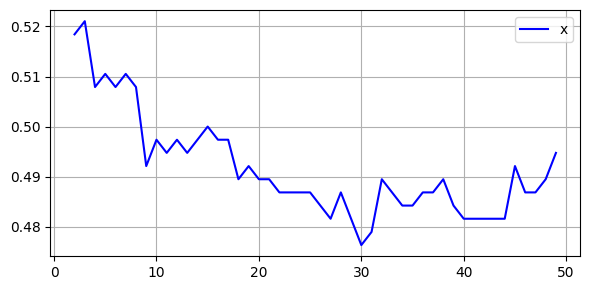

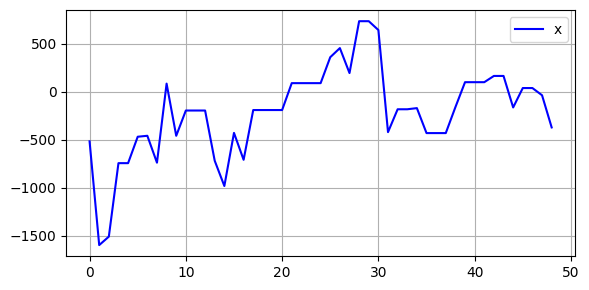

In [695]:
max_leaf_nodes = [None, *list(range(2, 50))]

res = {}
margins = []
for max_leaf_node in max_leaf_nodes:
    res[max_leaf_node], tree_pred = (score_model(X_train, X_valid, y_train, y_valid, model=RandomForestClassifier, preprocesor=preprocesor, max_leaf_nodes=max_leaf_node))
    margins.append(show_res(tree_pred, X_valid))

print(min(res.items(), key=lambda item: item[1]))
display_plot(max_leaf_nodes, res.values())
display_plot(list(range(0, len(margins))), margins)

model_perfomance.setdefault('RandomForestClassifier', {})
model_perfomance['RandomForestClassifier']['max_leaf_nodes'] = min(res.items(), key=lambda item: item[1])

## DecisionTreeRegressor

MAE: 0.6736842105263158 | Acc Score: 0.4842105263157895| kwargs={'max_leaf_nodes': 99}}e}(4, 0.4710526315789474)


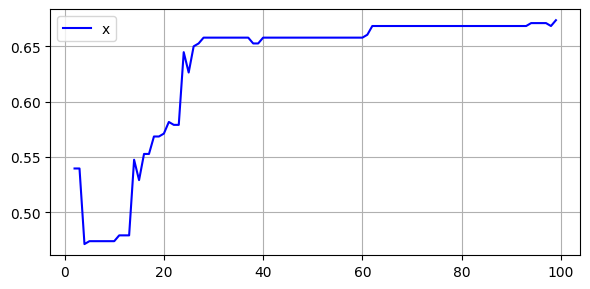

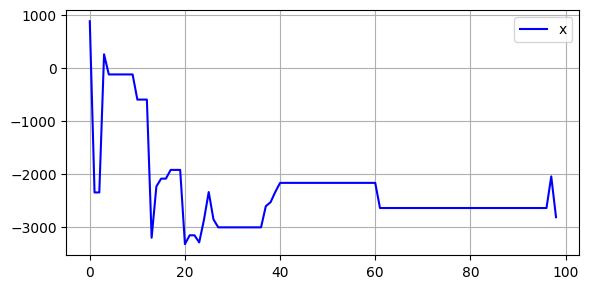

In [690]:
from sklearn.tree import DecisionTreeRegressor

max_leaf_nodes = [None, *list(range(2, 100))]

res = {}
margins = []
for max_leaf_node in max_leaf_nodes:
    res[max_leaf_node], tree_pred = (score_model(X_train, X_valid, y_train, y_valid, model=DecisionTreeRegressor, preprocesor=preprocesor, max_leaf_nodes=max_leaf_node))
    margins.append(show_res(tree_pred, X_valid))

print(min(res.items(), key=lambda item: item[1]))
display_plot(max_leaf_nodes, res.values())
display_plot(list(range(0, len(margins))), margins)

model_perfomance.setdefault('DecisionTreeRegressor', {})
model_perfomance['DecisionTreeRegressor']['max_leaf_nodes'] = min(res.items(), key=lambda item: item[1])

## RandomForestRegressor

(2, 0.5394736842105263)


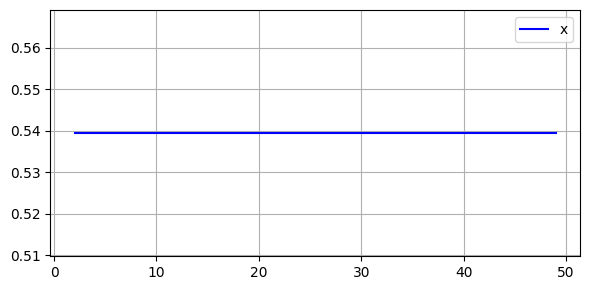

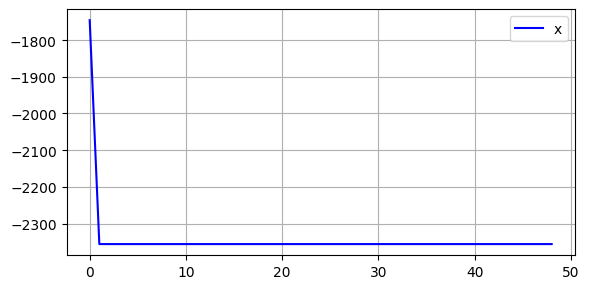

In [691]:
from sklearn.ensemble import RandomForestRegressor

max_leaf_nodes = [None, *list(range(2, 50))]

res = {}
margins = []
for max_leaf_node in max_leaf_nodes:
    res[max_leaf_node], tree_pred = score_model(
        X_train, X_valid, y_train, y_valid, 
        model=RandomForestRegressor, 
        preprocesor=preprocesor, 
        max_leaf_nodes=max_leaf_node,
        flush=False
    )
    margins.append(show_res(tree_pred, X_valid))


print(min(res.items(), key=lambda item: item[1]))
display_plot(max_leaf_nodes, res.values())
display_plot(list(range(0, len(margins))), margins)

model_perfomance.setdefault('RandomForestRegressor', {})
model_perfomance['RandomForestRegressor']['max_leaf_nodes'] = min(res.items(), key=lambda item: item[1])

MAE: 0.5394736842105263 | Acc Score: 0.4631578947368421| kwargs={'n_estimators': 147}}(27, 0.5342105263157895)


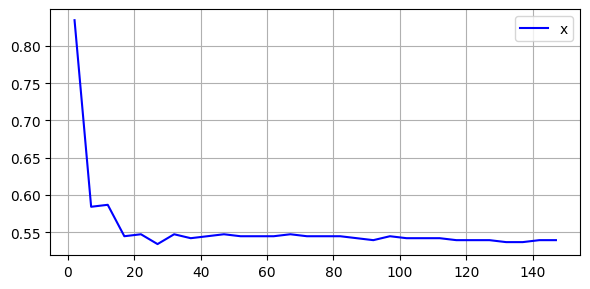

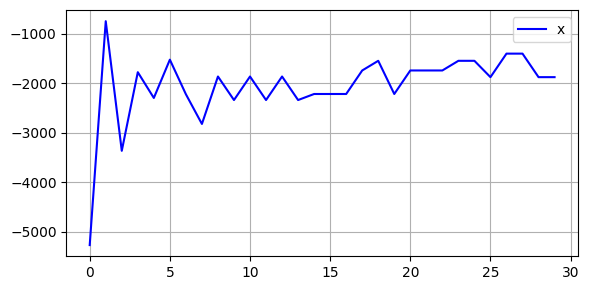

In [692]:
n_estimators = list(range(2, 150, 5))

res = {}
margins = []
for n_estimator in n_estimators:
    res[n_estimator], tree_pred = score_model(
        X_train, X_valid, y_train, y_valid, 
        model=RandomForestRegressor, 
        preprocesor=preprocesor, 
        n_estimators=n_estimator,
        flush=True,
    )
    margins.append(show_res(tree_pred, X_valid))


print(min(res.items(), key=lambda item: item[1]), sep='\n')
display_plot(n_estimators, res.values())
display_plot(list(range(0, len(margins))), margins)

model_perfomance.setdefault('RandomForestRegressor', {})
model_perfomance['RandomForestRegressor']['n_estimators'] = min(res.items(), key=lambda item: item[1])

MAE: 0.5394736842105263 | Acc Score: 0.4605263157894737| kwargs={'max_leaf_nodes': 47, 'n_estimators': 72}}2}('22 2', 0.5)


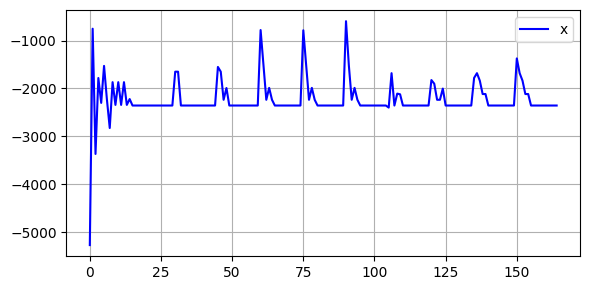

In [693]:
max_leaf_nodes = [None, *list(range(2, 50, 5))]
n_estimators = list(range(2, 75, 5))

res = {}
margins = []
for max_leaf_node in max_leaf_nodes:
    for n_estimator in n_estimators:
        res[f"{max_leaf_node} {n_estimator}"], tree_pred = score_model(
            X_train, X_valid, y_train, y_valid, 
            model=RandomForestRegressor, 
            preprocesor=preprocesor, 
            max_leaf_nodes=max_leaf_node,
            n_estimators=n_estimator,
            flush=True
        )
        margins.append(show_res(tree_pred, X_valid))

print(min(res.items(), key=lambda item: item[1]))
display_plot(list(range(0, len(margins))), margins)

model_perfomance.setdefault('RandomForestRegressor', {})
model_perfomance['RandomForestRegressor']['max_leaf + n_estimators'] = min(res.items(), key=lambda item: item[1])


## XGBRegressor

MAE: 0.6710526315789473 | Acc Score: 0.42105263157894735| kwargs={'n_estimators': 145}(5, 0.5368421052631579)


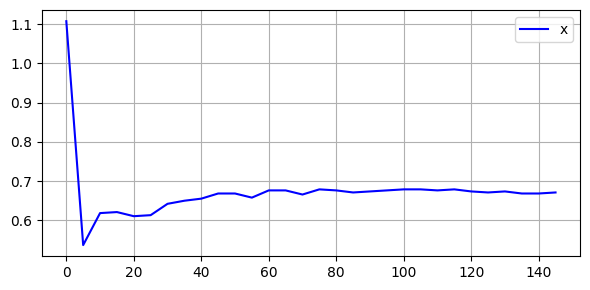

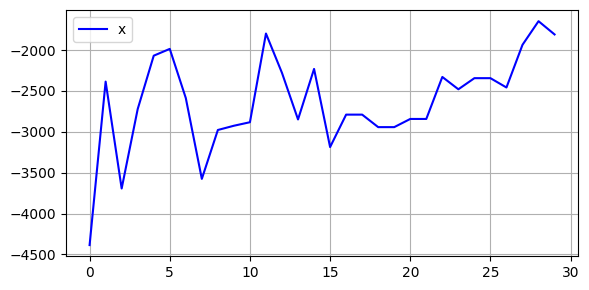

In [694]:
from xgboost import XGBRegressor


n_estimators = list(range(0, 150, 5))

res = {}
margins = []
for n_estimator in n_estimators:
    res[n_estimator], tree_pred = score_model(
        X_train, X_valid, y_train, y_valid, 
        model=XGBRegressor, 
        preprocesor=preprocesor, 
        n_estimators=n_estimator,
        flush=True,
    )
    margins.append(show_res(tree_pred, X_valid))


print(min(res.items(), key=lambda item: item[1]), sep='\n')
display_plot(n_estimators, res.values())
display_plot(list(range(0, len(margins))), margins)


model_perfomance['XGBRegressor'] = {}
model_perfomance['XGBRegressor']['n_estimators'] = min(res.items(), key=lambda item: item[1])

In [ ]:
import json

print(json.dumps(model_perfomance, indent=4))

In [762]:

feat = {
    'FTR': 'Final Result',
    'B365H': 'Bet365 home win odds',
    'B365D': 'Bet365 draw odds',
    'B365A': 'Bet365 away win odds',
}
res_df = df5[feat.keys()].copy()
res_df['p1'] = np.where(res_df['FTR'] == 'H', (res_df['B365H'] * 100)-100, np.where(res_df['B365H'] > 4 , 0, -100))
# res_df['p2'] = np.where(res_df['FTR'] == 'D', (res_df['B365D'] * 100)-100, -100)
res_df['p3'] = np.where(res_df['FTR'] == 'A', (res_df['B365A'] * 100)-100, np.where(res_df['B365A'] > 4 , 0, -100))


print('H:', (res_df.FTR == 'H').sum())
# print('D:', (res_df.FTR == 'D').sum())
print('A:', (res_df.FTR == 'A').sum())

print(res_df.p1.sum())
# print(res_df.p2.sum())
print(res_df.p3.sum())

print(res_df.head(20))

H: 172
A: 116
6401.0
9862.0
   FTR  B365H  B365D  B365A     p1     p3
0    H   1.14  10.00  19.00   14.0    0.0
1    A  12.00   6.50   1.22    0.0   22.0
2    D   1.95   3.60   3.60 -100.0 -100.0
3    H   2.62   3.20   2.75  162.0 -100.0
4    D   3.00   3.25   2.37 -100.0 -100.0
5    A   1.90   3.40   4.00 -100.0  300.0
6    H   1.30   5.25  10.00   30.0    0.0
7    D   2.20   3.20   3.40 -100.0 -100.0
8    A   4.50   3.75   1.72    0.0   72.0
9    H   2.10   3.30   3.50  110.0 -100.0
10   H   1.30   5.50  10.00   30.0    0.0
11   A   2.30   3.40   3.10 -100.0  210.0
12   D   2.55   3.25   2.87 -100.0 -100.0
13   H   1.72   3.80   4.75   72.0    0.0
14   H   2.25   3.30   3.30  125.0 -100.0
15   A   6.50   4.75   1.44    0.0   44.0
16   D   1.36   5.25   8.00 -100.0    0.0
17   H   2.55   3.10   2.90  155.0 -100.0
18   D   1.70   3.75   5.00 -100.0    0.0
19   D   3.30   3.30   2.25 -100.0 -100.0
